Step1. Import Module

Step2. Check Device

Step3. Download CIFAR10 Data

Step4. Check Data

Step5. Check Data

Step6. MLP Model 

Step7. Optimizer, Objective Function

Step8. Check Train data's Loss

Step8. Check Vaild data's Loss

Step9. Check Test set Accuracy 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn               #pytorch module 중 인공신경망 설계할때 필요한 함수
import torch.nn.functional as F     #nn중에서도 자주 이용되는 함수 F
from torchvision import transforms, datasets 

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else : 
    DEVICE = torch.device('cpu')
    
print('Using Pytorch version : ', torch.__version__, 'Device :', DEVICE)

Using Pytorch version :  1.9.1 Device : cpu


In [4]:
BATCH_SIZE = 32                      #Iteration = 전체데이터개수 / batch_size , back propagation을 진행하는 단위
EPOCHS = 10                          #Epochs는 존재하고 있는 Mini_batch를 전부 이용하는 횟수를 의미

In [5]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = True,
                                 download = True,                   #인터넷에서 다운로드
                                 transform = transforms.Compose([
                                     transforms.RandomHorizontalFlip(), #50%의 확률로 좌우반전
                                     transforms.ToTensor(), #nomalization and trans to tensor
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) #red, green,blue 순으로 0.5평균, 0.5표준편차로 정규화 
                                 ]))
test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = False,
                                  transform = transforms.Compose([
                                     transforms.RandomHorizontalFlip(), #50%의 확률로 좌우반전
                                     transforms.ToTensor(), #nomalization and trans to tensor
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) #red, green,blue 순으로 0.5평균, 0.5표준편차로 정규화 
                                 ]))
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [6]:
for (X_train, y_train) in train_loader:
    print('X_train :', X_train.size(),'type : ', X_train.type())
    print('y_train :', y_train.size(),'type :', y_train.type())
    break

X_train : torch.Size([32, 3, 32, 32]) type :  torch.FloatTensor
y_train : torch.Size([32]) type : torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

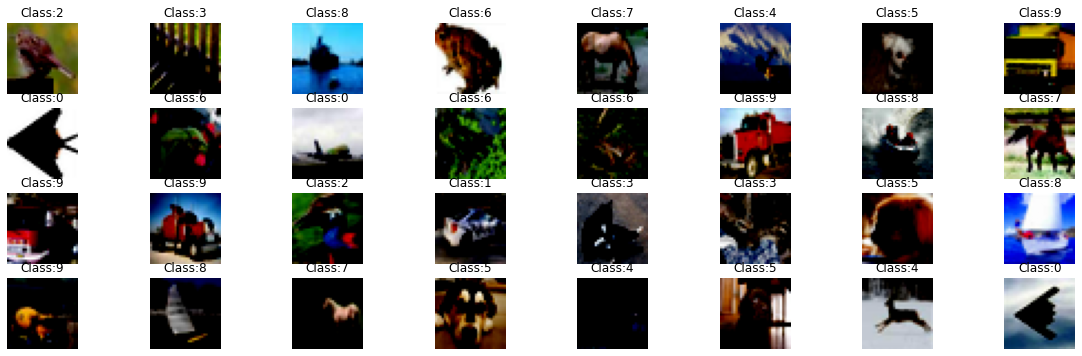

In [7]:
pltsize = 2
plt.figure(figsize=(10*pltsize, 3*pltsize))

for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i],(1,2,0))) #X_train[i]([channel],[height],[width]) --> X_train[i]([width],[height],[channel])
    plt.title('Class:'+ str(y_train[i].item()))

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
                    in_channels = 3,
                    out_channels = 8,
                    kernel_size = 3,
                    padding = 1) 
        self.conv2 = nn.Conv2d(
                    in_channels = 8,
                    out_channels = 16,
                    kernel_size = 3,
                    padding = 1) 
        self.pool = nn.MaxPool2d(
                    kernel_size = 2,
                    stride = 2)
        
        self.fc1 = nn.Linear(8*8*16, 64) #(1024,64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10) #10가지 class 원-핫 인코딩 
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
    
        x = x.view(-1, 8 * 8 * 16) # 2차원데이터를 1차원으로 flatten 
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [9]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [10]:
#학습데이터에 대한 모델 성능
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad() #zero로 초기화
        output = model(image)
        loss = criterion(output, label) #cross entropy로 loss값계산
        loss.backward() #계산된 loss값으로 back propagation을 통해 계산된 gradient값을 각 파라미터에 할당
        optimizer.step() #각 파라미터별로 할당된 gradient 값을 이용해 파라미터 값을 업데이트합니다
        
        if batch_idx % log_interval == 0 :
            print("Train Epochs : {} [{}/{}({:.0f}%)]|tTrain Loss: {:.6f}".format(
                Epoch, batch_idx*len(image),
                len(train_loader.dataset), 100.*batch_idx / len(train_loader),
                loss.item()))

In [11]:
#검증데이터에 대한 모델 성능
def evaluate(model, test_loader):
    model.eval()            #model을 평가상태로 바꾸기
    test_loss = 0       
    correct = 0
    with torch.no_grad():  #평가단계에 gradient 학습방지
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]   #제일큰확률찾기
            correct += prediction.eq(label.view_as(prediction)).sum().item() #올바르게 예측한 수 세기
    test_loss /= len(test_loader.dataset)  #test_loss(평균loss) = 지금까지계산된loss/minibatch개수
    test_accuracy = 100. * correct / len(test_loader.dataset) # 100* (올바르게 예측한 개수/minibatch개수)
    return test_loss, test_accuracy

In [12]:
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("/n[EPOCH:{}], /tTest Loss : {:.4f}, /tTest Accuracy: {:.2f} % /n".
         format(Epoch, test_loss, test_accuracy))

Train Epochs : 1 [0/50000(0%)]|tTrain Loss: 2.311460
Train Epochs : 1 [6400/50000(13%)]|tTrain Loss: 1.670547
Train Epochs : 1 [12800/50000(26%)]|tTrain Loss: 2.060194
Train Epochs : 1 [19200/50000(38%)]|tTrain Loss: 1.791497
Train Epochs : 1 [25600/50000(51%)]|tTrain Loss: 1.894693
Train Epochs : 1 [32000/50000(64%)]|tTrain Loss: 1.387537
Train Epochs : 1 [38400/50000(77%)]|tTrain Loss: 1.550119
Train Epochs : 1 [44800/50000(90%)]|tTrain Loss: 1.561492
/n[EPOCH:1], /tTest Loss : 0.0436, /tTest Accuracy: 48.99 % /n
Train Epochs : 2 [0/50000(0%)]|tTrain Loss: 1.586919
Train Epochs : 2 [6400/50000(13%)]|tTrain Loss: 1.497996
Train Epochs : 2 [12800/50000(26%)]|tTrain Loss: 1.477527
Train Epochs : 2 [19200/50000(38%)]|tTrain Loss: 0.939828
Train Epochs : 2 [25600/50000(51%)]|tTrain Loss: 1.163759
Train Epochs : 2 [32000/50000(64%)]|tTrain Loss: 1.150054
Train Epochs : 2 [38400/50000(77%)]|tTrain Loss: 1.205753
Train Epochs : 2 [44800/50000(90%)]|tTrain Loss: 1.397424
/n[EPOCH:2], /tTest L